In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import torch
import gpytorch
import tqdm
import importlib

base_dir = os.path.join(os.getcwd(), '../../')
sys.path.append(base_dir)

from src.models import VariationalCMEProcess
from src.likelihoods import CMEProcessLikelihood

## Simulation Data

For this 1D simulation, we work with field $f(x)$ and use an uniform aggregation process over segment centered on $y$ with radius $r$ as 

$$
g(y) = \int f(x)d\mathcal{U}_{[y-r, y+r]}(x)
$$

We choose $f$ in order to obtain a closed-form expression for $g$.

$$
f(x) = \cos\left(\frac{x + \pi}{2}\right) + \sin(x)
$$

$$
g(y) = \left[2\sin\left(\frac{x + \pi}{2}\right) - \cos(x)\right]_{y-r}^{y+r}
$$

In [2]:
def generate_toy_data(radius, n_bags, noise_std):
    # Define base individuals and bags values
    x = 8 * np.pi * torch.rand(400)
    y = 8 * np.pi * torch.rand(n_bags)

    # Adapt range of individuals to aggregation areas for each bag
    bags_masks = [(x >= a - radius) & (x <= a + radius) for a in y]
    individuals = torch.cat([x[mask] for mask in bags_masks])
    bags_sizes = [torch.sum(mask).item() for mask in bags_masks]

    # Compute groundtruth latent individuals GP values
    latent_individuals = torch.cos((x + np.pi) / 2) + torch.sin(x)
    primitive = lambda x: 2 * torch.sin((x + np.pi) / 2) - torch.cos(x)
    
    # Compute aggregate bag values and add observation noise
    latent_aggregate_targets = (primitive(y + radius) - primitive(y - radius)) / (2 * radius)
    aggregate_targets = latent_aggregate_targets + noise_std * torch.randn_like(latent_aggregate_targets)
    return x, y, bags_sizes, individuals, latent_individuals, latent_aggregate_targets, aggregate_targets 

torch.random.manual_seed(51)

radius = 2
n_bags = 15
noise_std = 0.025

buffer = generate_toy_data(radius=radius, n_bags=n_bags, noise_std=noise_std)
x, y, bags_sizes, individuals, latent_individuals, latent_aggregate_targets, aggregate_targets = buffer
extended_y = torch.cat([x.repeat(bag_size) for x, bag_size in zip(y, bags_sizes)])

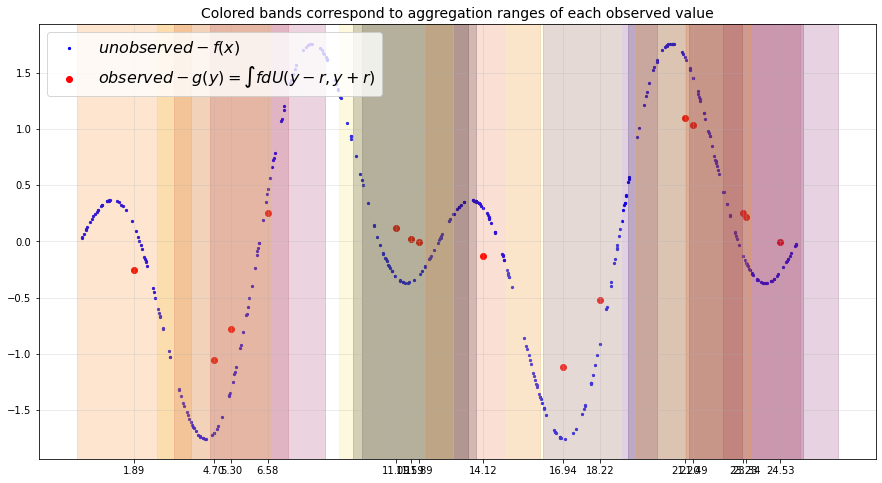

In [3]:
fig, ax = plt.subplots(1, 1, figsize=(15, 8))

ax.scatter(x, latent_individuals, color='blue', s=5, label=r'$unobserved - f(x)$')

colors = plt.cm.inferno(np.linspace(0, 1, len(y)))
for a, c in zip(y, colors):
    ax.axvspan(a - radius, a + radius, alpha=0.2, color=c)

ax.scatter(y, latent_aggregate_targets, c='red', label=r'$observed - g(y) = \int fdU(y - r, y + r)$')
ax.set_xticks(y)

ax.grid(alpha=0.3)
ax.set_title("Colored bands correspond to aggregation ranges of each observed value", fontsize=14)
plt.legend(fontsize=16)
plt.show()

## Define Variational GP Disaggregation Model

We place prior $f\sim\operatorname{GP}(m, k)$ on $f$. We hence need to define a mean function $m$ acting on $x$ and a kernel function $k$ acting on $x$.

Additionally, to leverage conditional mean embedding computation of aggregate mean $\mathbb{E}[m(X)|Y=y]$ and aggregate covariance $\mathbb{E}[k(X, X')|Y=y, Y=y']$ we need to define a kernel function $\ell$ acting on $y$.

We also need to define a set of inducing points $u$ for the learnt variational distribution $q(u)\sim\mathcal{N}(\mu_u, \Sigma_u)$

In [4]:
# Define mean module m for xs
individuals_mean = gpytorch.means.ZeroMean()

# Define kernel module k for xs
individuals_kernel = gpytorch.kernels.RBFKernel()

# Define kernel module l for ys
bag_kernel = gpytorch.kernels.RBFKernel()

# Define tensor of inducing points
inducing_points = torch.linspace(0, 8 * np.pi, 50)

# Initialize variational DP disaggregation model
model = VariationalCMEProcess(inducing_points=inducing_points,
                              individuals_mean=individuals_mean, 
                              individuals_kernel=individuals_kernel,
                              bag_kernel=bag_kernel,
                              lbda=1e-8)

likelihood = CMEProcessLikelihood()

## Maximum Likelihood Estimate of Hyperparameters

We tune the observation noise $\sigma^2$, above covariance modules $k$ and $\ell$ hyperparameters, inducing points location $u$ and variational distribution parameters $\mu_u, \Sigma_u$ to maximize the ELBO loss, i.e. minimize the KL-divergence between $q(u)$ and $p(u|z)$ where $z = g(y) + \sigma^2 \varepsilon$ is a noised version of aggregate observations.

In [5]:
# Setup modules to training mode
model.train()
likelihood.train()

# Define optimizer and gpytorch elbo estimation module
parameters = list(model.parameters()) + list(likelihood.parameters())
optimizer = torch.optim.Adam(params=parameters, lr=0.01)
elbo = gpytorch.mlls.VariationalELBO(likelihood, model, num_data=len(individuals))

# Setup number of training epochs
epochs = 50
epoch_iter = tqdm.notebook.tqdm(range(epochs), desc="Epoch")


for epoch in epoch_iter:
    # Zero-out remaining gradients
    optimizer.zero_grad()
    
    # Compute q(f)
    q = model(individuals)
    
    # Compute tensors needed for ELBO computation
    buffer = model.get_elbo_computation_parameters(bags_values=y,
                                                   extended_bags_values=extended_y)
    root_inv_extended_bags_covar, bags_to_extended_bags_covar = buffer

    # Compute negative ELBO loss
    loss = -elbo(variational_dist_f=q, 
                 target=aggregate_targets,
                 root_inv_extended_bags_covar=root_inv_extended_bags_covar,
                 bags_to_extended_bags_covar=bags_to_extended_bags_covar)
    
    # Take gradient step
    loss.backward()
    optimizer.step()

    epoch_iter.set_postfix(loss=loss.item())

## Compute variational posterior q(f)

In [6]:
# Set model to evaluation mode
model.eval()
likelihood.eval()

with torch.no_grad():
    individuals_posterior = model(x)

/Users/dieze/.pyenv/versions/torch-3.8/lib/python3.8/site-packages/gpytorch/utils/cholesky.py:46: NumericalWarning: A not p.d., added jitter of 1.0e-04 to the diagonal
  warnings.warn(f"A not p.d., added jitter of {jitter_new:.1e} to the diagonal", NumericalWarning)


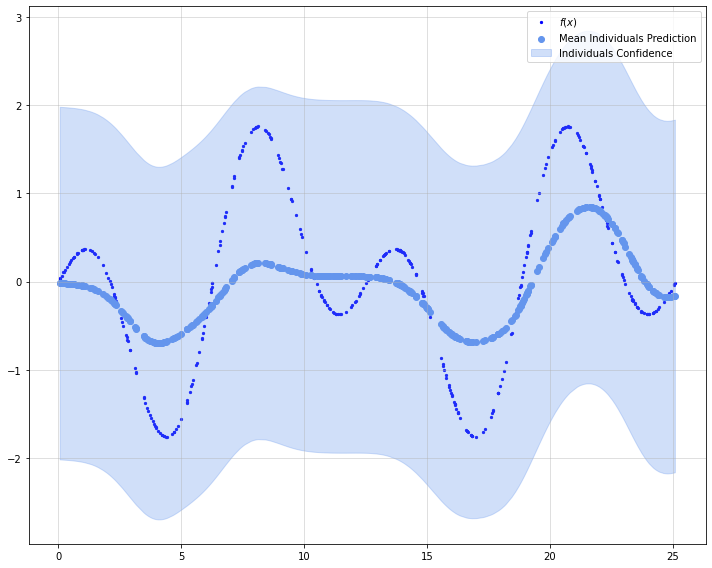

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

lower, upper = individuals_posterior.confidence_region()
lower, upper = lower.detach(), upper.detach()

sorted_idx = np.argsort(x.numpy())
sorted_x = x[sorted_idx]
lower, upper = lower[sorted_idx], upper[sorted_idx]

ax.scatter(x, latent_individuals,  color='blue', s=5, label=r'$f(x)$')
ax.scatter(x, individuals_posterior.mean.detach(), color='cornflowerblue', label='Mean Individuals Prediction')
ax.fill_between(x=sorted_x, y1=lower.numpy(), y2=upper.numpy(), color='cornflowerblue', alpha=0.3, label='Individuals Confidence')

ax.grid(alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()